In [1]:
import os
from matplotlib import test
import tensorflow as tf
# import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras import datasets, layers, models

In [2]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [3]:
data_path = "../../../ISIC_Data/ISIC-2017_Training_Data/*.jpg"
mask_path = "../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/*.png"

In [4]:
# Process ground truth csv
import csv
import pathlib
filename = "ISIC_0000000"
img_path = "../../../ISIC_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg"

with open("../../../ISIC_Data/ISIC-2017_Training_Part3_GroundTruth.csv", "r") as infile:
    data_groundtruth_dict = list(csv.DictReader(infile))

In [5]:
def prepareData(filenames):
    # Lookup image in ground truth csv to determine if malignant or benign
    # image_id = tf.strings.split(filenames, "/")[-1]  # Get filename
    # image_id = tf.strings.split(image_id, ".")[0]      # Remove file extension

    # # Look up image in csv to determine label
    # for row in data_groundtruth_dict:
    #     if row['image_id'] == image_id:
    #         label = tf.strings.to_number(row['melanoma'])
    #     else:
    #         label = tf.strings.to_number('0.0')

    raw_image = tf.io.read_file(filenames)
    raw_image = tf.io.decode_jpeg(raw_image, channels=3)

    # Resize
    raw_image = tf.image.resize_with_pad(raw_image, IMAGE_HEIGHT, IMAGE_WIDTH)

    # Normalise
    raw_image = raw_image / 255.0

    return raw_image #, label


def prepareMasks(filenames):
    new_img = tf.io.read_file(filenames)
    raw_image = tf.io.decode_png(new_img, channels=1)

    # Resize
    raw_image = tf.image.resize_with_pad(raw_image, IMAGE_HEIGHT, IMAGE_WIDTH)

    # Normalise
    raw_image = raw_image / 255.0

    # Set image thresholds
    raw_image = tf.math.round(raw_image)

    return raw_image

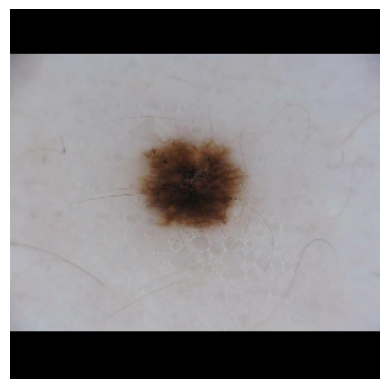

In [6]:
image = prepareData("../../../ISIC_Data/ISIC-2017_Training_Data/ISIC_0000001.jpg")

# def show(image, label):
#     plt.figure()
#     plt.imshow(image)
#     plt.title("melanoma" if label.numpy() == 1.0 else "benign")
#     plt.axis('off')

def show(image):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

show(image)

def process_raw(data_path, mask_path):
    data = prepareData(data_path)

    mask = prepareMasks(mask_path)

    return data, mask

In [9]:
import glob

g_data = sorted(glob.glob(data_path))
g_mask = sorted(glob.glob(mask_path))

In [47]:
def indicies_by_value(value):
    return tf.where(tf.equal(value, True))[:, -1]

def mask_to_bounding_box(mask_image):
    # Takes mask as input and outputs bounding box Tensor
    rows = tf.math.count_nonzero(mask_image, axis=0, keepdims=None, dtype=tf.bool)
    rows = tf.squeeze(rows, axis=1)
    row_index = indicies_by_value(rows)

    columns = tf.math.count_nonzero(mask_image, axis=1, keepdims=None, dtype=tf.bool)
    columns = tf.squeeze(columns, axis=1)
    # Convert to indicies
    col_index = indicies_by_value(columns)

    y_min = col_index[0]    # First mask pixel
    y_max = col_index[-1]   # Last mask pixel
    x_min = row_index[0]    
    x_max = row_index[-1]

    image = tf.image.convert_image_dtype(mask_image, dtype=tf.float32)
    img = tf.expand_dims(image, axis=0)
    img = tf.reshape(img, shape=[1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

    box = tf.stack([y_min, x_min, y_max, x_max], axis=0)
    box = tf.math.divide(box, IMAGE_HEIGHT)
    box = box.numpy()
    box = box.reshape([1,1,4])

    return box
    # box = np.array([0.1, 0.2, 0.5, 0.9])
    # box = tf.convert_to_tensor(box, dtype="float32")
    # box = tf.reshape(box, [1, 1, 4])

image = prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png')

print(image.shape)
box = mask_to_bounding_box(image)
box = tf.squeeze(box)

print(box)


(256, 256, 1)
tf.Tensor([0.16796875 0.05078125 0.73828125 0.875     ], shape=(4,), dtype=float64)


In [68]:
def box_details_extraction(box):
    # Determine center coordinates
    full_index = tf.math.multiply(box, IMAGE_HEIGHT)
    x_size = tf.math.subtract(full_index[0][0][3], full_index[0][0][1])
    x_size = tf.math.divide(x_size, IMAGE_WIDTH)
    y_size = tf.math.subtract(full_index[0][0][2], full_index[0][0][0])
    y_size = tf.math.divide(y_size, IMAGE_HEIGHT)

    center_x = tf.math.divide(x_size, 2.0)
    center_y = tf.math.divide(y_size, 2.0)

    return np.array([center_x, center_y, x_size, y_size])

image = prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png')
box = mask_to_bounding_box(image)

print(box_details_extraction(box))

[0.41210938 0.28515625 0.82421875 0.5703125 ]


In [86]:
# Generate .txt files for each mask
# In YOLO form -> Prob, b_center_x, b_center_y, b_width, b_height, class
# Where 0 is benign and 1 is melenoma

def get_mask_id(mask_path):
    mask_id = mask_path.split("\\")[-1]  # Get filename
    mask_id = mask_id.split("_segmentation")[0]  # Remove file extension

    return mask_id

def yolo_mask_encode(mask_path, mask_id):
    # Look up image in csv to determine label
    label = 0   # Benign
    for row in data_groundtruth_dict:
        if row['image_id'] == mask_id:
            label = tf.strings.to_number(row['melanoma'])
            break

    label = tf.cast(label, dtype=tf.int32)

    mask_image = prepareMasks(mask_path)

    bounding_box = mask_to_bounding_box(mask_image)

    box_details = box_details_extraction(box)
    
    # yolo_format = tf.convert_to_tensor([1, box_details[0], box_details[1], box_details[2], box_details[3], label], dtype=tf.float32)
    yolo_format = tf.strings.join([1, box_details[0], box_details[1], box_details[2], box_details[3], label])
    
    return yolo_format

for mask_path in g_mask:
    mask_id = get_mask_id(mask_path)
    # yolo_data = tf.strings.as_string(yolo_mask_encode(mask_path, mask_id))
    tf.io.write_file(f"{mask_id}.txt", mask_id)
    break
    


In [7]:


# Generate

train_ds = tf.data.Dataset.from_tensor_slices((g_data, g_mask))
train_ds = train_ds.map(process_raw)

print(train_ds)

# image_batch = train_ds.batch(4)

# i = 0
# while (i < 4):
#     single_ds = image_batch.take(1)
#     print(single_ds[0])

# ISIC_Data = tf.data.Dataset.list_files(data_path, shuffle=False)
# preData = ISIC_Data.map(prepareData)

# Mask_Data = tf.data.Dataset.list_files(mask_path, shuffle=False)
# preMasks = Mask_Data.map(prepareMasks)

# data = preData.enumerate()
# for element in data:
#     break
# print(data)

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None))>


(6, 256, 256, 3) (6, 256, 256, 1)
(256, 256, 1)
pre show dims
(256, 256, 3) [[[0.16796875 0.05078125 0.73828125 0.875     ]]]
(6, 256, 256, 3) (6, 256, 256, 1)
(256, 256, 1)
pre show dims
(256, 256, 3) [[[0.3515625  0.33984375 0.63671875 0.66796875]]]
(6, 256, 256, 3) (6, 256, 256, 1)
(256, 256, 1)
pre show dims
(256, 256, 3) [[[0.25       0.2109375  0.734375   0.76171875]]]
(6, 256, 256, 3) (6, 256, 256, 1)
(256, 256, 1)
pre show dims
(256, 256, 3) [[[0.2734375  0.140625   0.7890625  0.75390625]]]
(6, 256, 256, 3) (6, 256, 256, 1)
(256, 256, 1)
pre show dims
(256, 256, 3) [[[0.2890625 0.265625  0.7578125 0.71875  ]]]
(6, 256, 256, 3) (6, 256, 256, 1)
(256, 256, 1)
pre show dims
(256, 256, 3) [[[0.22265625 0.125      0.78515625 0.7890625 ]]]


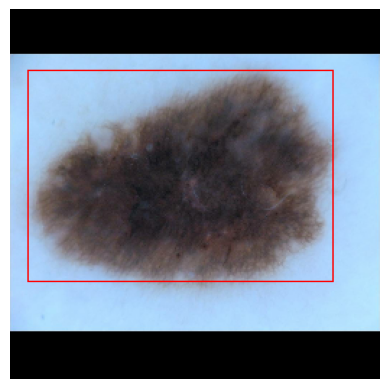

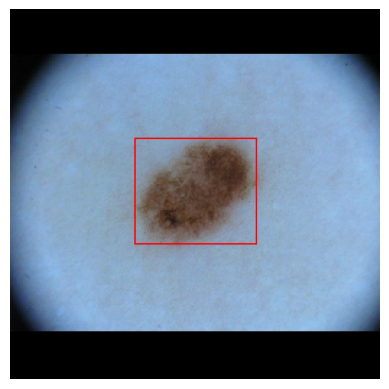

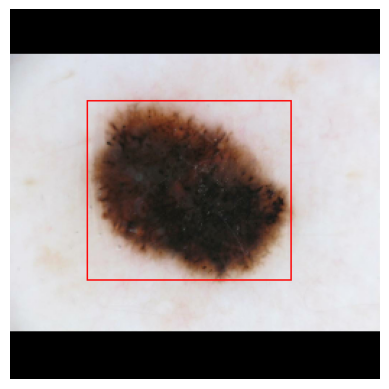

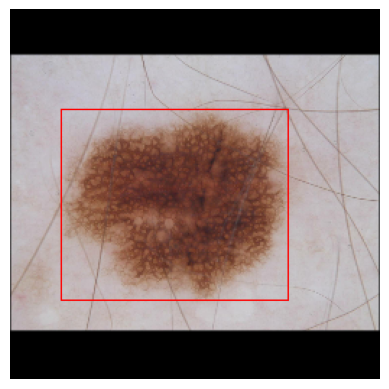

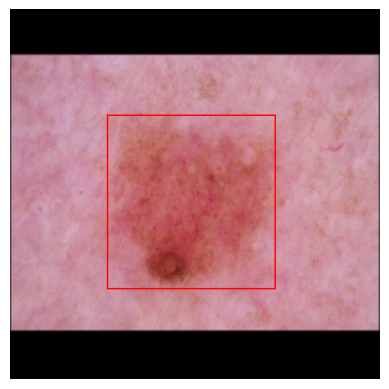

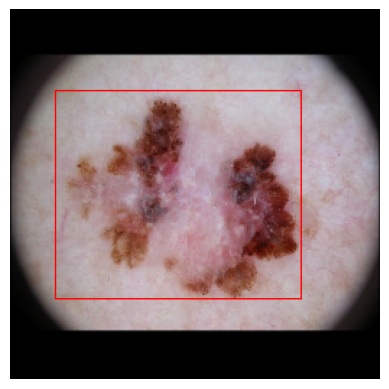

In [65]:
BATCH_SIZE = 6
batch_ds = train_ds.batch(BATCH_SIZE)

# for image in batch_ds.take(4):
i = 0
it = iter(batch_ds)

while i < BATCH_SIZE:
    image, mask = next(it)

    print(image.shape, mask.shape)
    # show(image.numpy()[0])
    # show(mask.numpy()[0])

    box = mask_to_bounding_box(mask.numpy()[0])
    colour = [[1.0, 0.0, 0.0]]
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image[0], [1, 256, 256, 3])

    print('pre show dims')
    print(image[0].shape, box)
    bbox = tf.image.draw_bounding_boxes(image, box, colour)

    show(bbox.numpy()[0])
    i += 1

In [74]:
# Establish YOLOv1 Output
S = 7
B = 2
C = 2   # Melanoma or Benign

output_tensor = tf.zeros([S, S, B*5+C])

print(output_tensor)

tf.Tensor(
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.